<a href="https://colab.research.google.com/github/StanleyLiangYork/Advance_NN_techniques/blob/main/GAN_structures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import shutil
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

Basic GAN

In [2]:
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential(
        [
            tf.keras.Input(shape=in_shape),
            layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),  # 28 -- 14
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),  # 14 -- 7
            layers.LeakyReLU(alpha=0.2),
            layers.GlobalMaxPooling2D(),
            layers.Dropout(0.4),
            layers.Dense(1)  # 128 -- 1
        ], name="discriminator"
    )
    return model
discriminator = define_discriminator()

In [3]:
def define_generator(latent_dim=128):
  model = keras.Sequential(
      [
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"), # 7 -- 14
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"), # 14 -- 28
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
       ],
       name="generator")
  return model

In [23]:
generator = define_generator()
discriminator = define_discriminator()

# Instantiate one optimizer for the discriminator and another for the generator.
d_optimizer = keras.optimizers.Adam(learning_rate=0.0002)
g_optimizer = keras.optimizers.Adam(learning_rate=0.0002)

# Use a Binary Cross-Entropy (BCE) loss function.
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function
def get_noise(n_samples, latent_dim=128):
  random_latent_vectors = tf.random.normal(shape=(n_samples, latent_dim))
  return random_latent_vectors


@tf.function
def train_step(real_images):
  batch_size = real_images.shape[0]
  z_input = get_noise(n_samples=batch_size)
  generated_images = generator(z_input)
  combined_images = tf.concat([generated_images, real_images], axis=0)
  # Assemble labels discriminating real from fake images
  labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((real_images.shape[0], 1))], axis=0)
  # Add random noise to the labels - important trick!
  labels += 0.05 * tf.random.uniform(labels.shape)

  # Train the discriminator
  with tf.GradientTape() as tape:
    tape.watch(combined_images)
    predictions = discriminator(combined_images)
    d_loss = loss_fn(labels, predictions)
  grads = tape.gradient(d_loss, discriminator.trainable_weights)
  d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

  # Sample random points in the latent space
  z_input = get_noise(n_samples=batch_size)
  misleading_labels = tf.zeros((batch_size, 1))

  # Train the generator (note that we should *not* update the weights of the discriminator)!
  with tf.GradientTape() as tape:
    tape.watch(z_input)
    predictions = discriminator(generator(z_input))
    g_loss = loss_fn(misleading_labels, predictions)
  grads = tape.gradient(g_loss, generator.trainable_weights)
  g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
  return d_loss, g_loss, generated_images

In [24]:
if not os.path.exists('syn_images'):
  folder = os.mkdir('syn_images')

batch_size = 512

# Prepare the dataset. We use both the training & test MNIST digits.
def load_digits(batch_size=512):
  (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
  all_digits = np.concatenate([x_train, x_test])
  all_digits = all_digits.astype("float32") / 255.0
  all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
  dataset = tf.data.Dataset.from_tensor_slices(all_digits)
  dataset = dataset.shuffle(buffer_size=batch_size).prefetch(buffer_size=batch_size).batch(batch_size)
  return dataset

dataset = load_digits()

In [25]:
epochs = 30  # In practice you need at least 20 epochs to generate nice digits.
save_dir = './syn_images'
history = {}
history['d_loss'] = []
history['g_loss'] = []

for epoch in range(epochs):
    print("\nStart epoch", epoch)
    d_loss_list = []
    g_loss_list = []


    for step, real_images in enumerate(dataset):
        # Train the discriminator & generator on one batch of real images.
        d_loss, g_loss, generated_images = train_step(real_images)
        d_loss_list.append(d_loss)
        g_loss_list.append(g_loss)

        # Logging.
        if step % 200 == 0:
            # Print metrics
            print("discriminator loss at step %d: %.2f" % (step, d_loss))
            print("adversarial loss at step %d: %.2f" % (step, g_loss))

            # Save one generated image
            img = tf.keras.preprocessing.image.array_to_img(
                generated_images[0] * 255.0, scale=False
            )
            img.save(os.path.join(save_dir, "generated_img" + str(step) + ".png"))
    
    print("------End of epoch: {epoch}------")
    mean_d_loss = np.array(d_loss_list).mean()
    mean_g_loss = np.array(g_loss_list).mean()
    history['d_loss'].append(mean_d_loss)
    history['g_loss'].append(mean_g_loss)
    print("discriminator loss at epoch %d: %.2f" % (epoch, mean_d_loss))
    print("adversarial loss at epoch %d: %.2f" % (epoch, mean_g_loss))


Start epoch 0
discriminator loss at step 0: 0.72
adversarial loss at step 0: 0.74
------End of epoch: {epoch}------
discriminator loss at epoch 0: 0.49
adversarial loss at epoch 0: 0.81

Start epoch 1
discriminator loss at step 0: 0.29
adversarial loss at step 0: 1.01
------End of epoch: {epoch}------
discriminator loss at epoch 1: 0.47
adversarial loss at epoch 1: 1.07

Start epoch 2
discriminator loss at step 0: 0.49
adversarial loss at step 0: 0.88
------End of epoch: {epoch}------
discriminator loss at epoch 2: 0.31
adversarial loss at epoch 2: 1.65

Start epoch 3
discriminator loss at step 0: 0.18
adversarial loss at step 0: 2.53
------End of epoch: {epoch}------
discriminator loss at epoch 3: 0.54
adversarial loss at epoch 3: 1.22

Start epoch 4
discriminator loss at step 0: 0.63
adversarial loss at step 0: 0.98
------End of epoch: {epoch}------
discriminator loss at epoch 4: 0.64
adversarial loss at epoch 4: 0.98

Start epoch 5
discriminator loss at step 0: 0.58
adversarial los

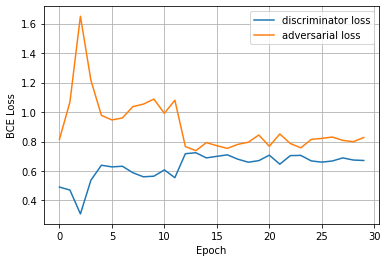

In [26]:
def plot_loss(history):
  plt.plot(history['d_loss'], label='discriminator loss')
  plt.plot(history['g_loss'], label='adversarial loss')
  # plt.ylim([0, 1.5])
  plt.xlabel('Epoch')
  plt.ylabel('BCE Loss')
  plt.legend()
  plt.grid(True)


plot_loss(history)

In [27]:
from matplotlib import pyplot as plt

def show_plot(examples, n):
  plt.figure(figsize=(12,12))
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis(False)
    # plt.tight_layout(True)
    plt.imshow(examples[i, :, :, 0], cmap='gray_r')
  plt.show()

Produce some fake images

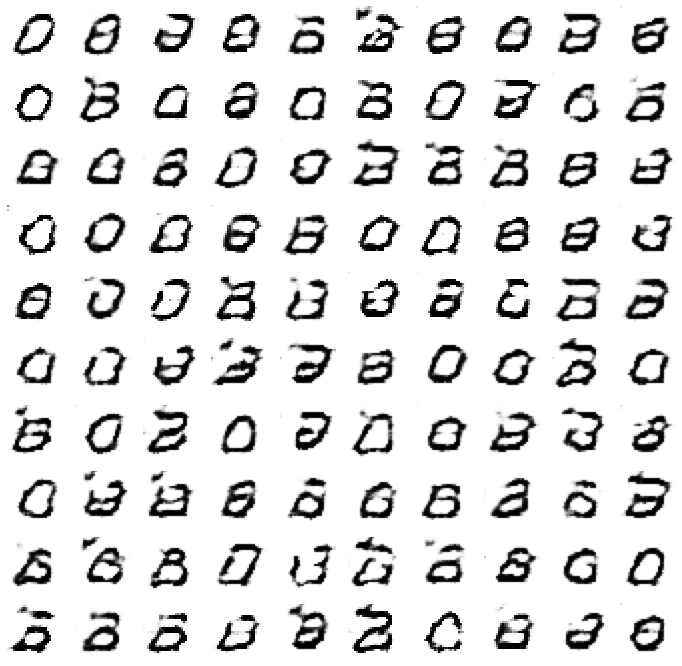

In [28]:
gen_images = generator(get_noise(100, 128))
show_plot(gen_images, 10)

Train the fashion dataset

In [33]:
from tensorflow.keras.datasets.fashion_mnist import load_data

def get_fashion(batch_size=512):
  (trainX, trainy), (testX, testy) = load_data()
  all_fashions = np.concatenate([trainX, testX])
  all_fashions = all_fashions.astype("float32") / 255.0
  all_fashions = np.reshape(all_fashions, (-1, 28, 28, 1))
  dataset = tf.data.Dataset.from_tensor_slices(all_fashions)
  dataset = dataset.shuffle(buffer_size=batch_size).prefetch(buffer_size=batch_size).batch(batch_size)
  return dataset

In [ ]:
dataset = get_fashion()

4423680/4422102 [==============================] - 0s 0us/step


Re-initiate the generator and the discriminator

In [ ]:
discriminator = define_discriminator()
generator = define_generator()

In [ ]:
# Instantiate one optimizer for the discriminator and another for the generator.
d_optimizer = keras.optimizers.Adam(learning_rate=0.0002)
g_optimizer = keras.optimizers.Adam(learning_rate=0.0002)

# Use a Binary Cross-Entropy (BCE) loss function.
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function
def get_noise(n_samples, latent_dim=128):
  random_latent_vectors = tf.random.normal(shape=(n_samples, latent_dim))
  return random_latent_vectors


@tf.function
def train_step(real_images):
  batch_size = real_images.shape[0]
  z_input = get_noise(n_samples=batch_size)
  generated_images = generator(z_input)
  combined_images = tf.concat([generated_images, real_images], axis=0)
  # Assemble labels discriminating real from fake images
  labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((real_images.shape[0], 1))], axis=0)
  # Add random noise to the labels - important trick!
  labels += 0.05 * tf.random.uniform(labels.shape)

  # Train the discriminator
  with tf.GradientTape() as tape:
    tape.watch(combined_images)
    predictions = discriminator(combined_images)
    d_loss = loss_fn(labels, predictions)
  grads = tape.gradient(d_loss, discriminator.trainable_weights)
  d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

  # Sample random points in the latent space
  z_input = get_noise(n_samples=batch_size)
  misleading_labels = tf.zeros((batch_size, 1))

  # Train the generator (note that we should *not* update the weights of the discriminator)!
  with tf.GradientTape() as tape:
    tape.watch(z_input)
    predictions = discriminator(generator(z_input))
    g_loss = loss_fn(misleading_labels, predictions)
  grads = tape.gradient(g_loss, generator.trainable_weights)
  g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
  return d_loss, g_loss, generated_images

In [ ]:
from matplotlib import pyplot as plt
from keras.datasets.fashion_mnist import load_data
import os


if not os.path.exists('syn_images'):
  folder = os.mkdir('syn_images')

epochs = 30  # In practice you need at least 20 epochs to generate nice digits.
save_dir = './syn_images'
history = {}
history['d_loss'] = []
history['g_loss'] = []
for epoch in range(epochs):
    print("\nStart epoch", epoch)
    d_loss_list = []
    g_loss_list = []


    for step, real_images in enumerate(dataset):
        # Train the discriminator & generator on one batch of real images.
        d_loss, g_loss, generated_images = train_step(real_images)
        d_loss_list.append(d_loss)
        g_loss_list.append(g_loss)

        # Logging.
        if step % 200 == 0:
            # Print metrics
            print("discriminator loss at step %d: %.2f" % (step, d_loss))
            print("adversarial loss at step %d: %.2f" % (step, g_loss))

            # Save one generated image
            img = tf.keras.preprocessing.image.array_to_img(
                generated_images[0] * 255.0, scale=False
            )
            img.save(os.path.join(save_dir, "generated_img" + str(step) + ".png"))
    
    print("------End of epoch: {epoch}------")
    mean_d_loss = np.array(d_loss_list).mean()
    mean_g_loss = np.array(g_loss_list).mean()
    history['d_loss'].append(mean_d_loss)
    history['g_loss'].append(mean_g_loss)
    print("discriminator loss at epoch %d: %.2f" % (epoch, mean_d_loss))
    print("adversarial loss at epoch %d: %.2f" % (epoch, mean_g_loss))


Start epoch 0
discriminator loss at step 0: 0.69
adversarial loss at step 0: 0.69
------End of epoch: {epoch}------
discriminator loss at epoch 0: 0.60
adversarial loss at epoch 0: 0.72

Start epoch 1
discriminator loss at step 0: 0.70
adversarial loss at step 0: 0.80
------End of epoch: {epoch}------
discriminator loss at epoch 1: 0.56
adversarial loss at epoch 1: 1.06

Start epoch 2
discriminator loss at step 0: 0.82
adversarial loss at step 0: 1.06
------End of epoch: {epoch}------
discriminator loss at epoch 2: 0.59
adversarial loss at epoch 2: 1.05

Start epoch 3
discriminator loss at step 0: 0.68
adversarial loss at step 0: 0.95
------End of epoch: {epoch}------
discriminator loss at epoch 3: 0.56
adversarial loss at epoch 3: 0.99

Start epoch 4
discriminator loss at step 0: 0.35
adversarial loss at step 0: 1.35
------End of epoch: {epoch}------
discriminator loss at epoch 4: 0.58
adversarial loss at epoch 4: 1.13

Start epoch 5
discriminator loss at step 0: 0.61
adversarial los

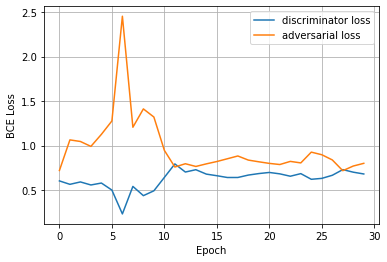

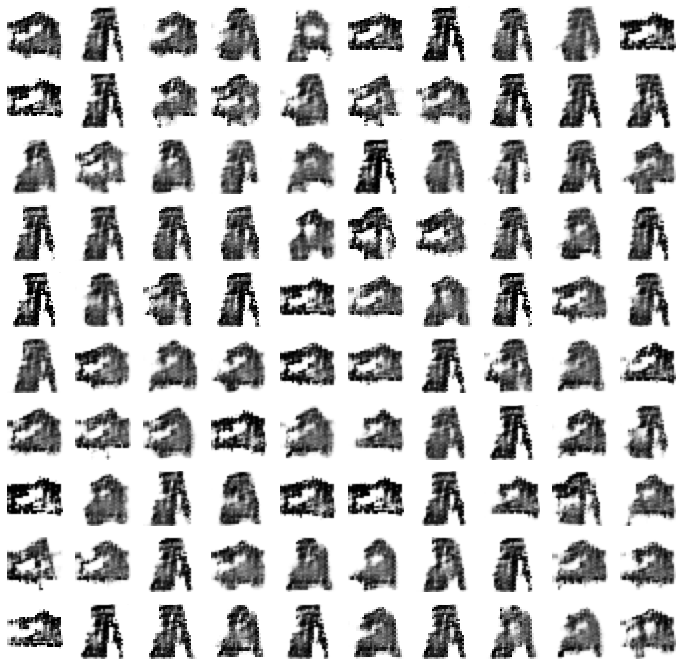

In [ ]:
plot_loss(history)
gen_images = generator(get_noise(100, 128))
show_plot(gen_images, 10)

Train the GAN with Wasserstein Loss

In [34]:
generator = define_generator()
critic = define_discriminator()

Define the loss function of the generator and the critic

In [35]:
# define the optimizer
d_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
g_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
@tf.function
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

# Define the loss functions for the generator.
# minimize the inverted == maximize
@tf.function
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

Define the Gradient Penalty

In [36]:
# define the Gradient Penalty
@tf.function
def gradient_penalty(batch_size, real_images, fake_images, discriminator):
  # use an interpolated image to add to the discriminator loss

  # Get the interpolated image
  # alpha = tf.random.normal(shape=[batch_size,1,1,1], mean=0.0, stddev=1.0)
  epsilon = tf.random.normal(shape=[batch_size,1,1,1], mean=0.0, stddev=1.0)
  # diff = fake_images - real_images
  # interpolated = real_images + alpha * diff
  mixed_images = real_images * epsilon + fake_images * (1.0 - epsilon)

  # compute the gradient of critic(mixed_images)
  with tf.GradientTape() as gp_tape:
    gp_tape.watch(mixed_images)
    # 1. Get the discriminator output for this interpolated image.
    pred = discriminator(mixed_images, training=True)

  # 2. Calculate the gradients w.r.t to this interpolated image.
  grads = gp_tape.gradient(pred, mixed_images)
  # 3. Calculate the norm of the gradients.
  # the reduce sum preserve the batch size -- each image has a norm
  norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
  # get the gradient penalty - substract by 1 so that the penalty always least than 1
  gradient_penalty = tf.reduce_mean((norm - 1.0) ** 2)
  return gradient_penalty

In [37]:
@tf.function
def train_step(real_images, Lambda=10.0):
  batch_size = real_images.shape[0]
  # 1. Train the discriminator (critic) and get the discriminator loss for 3 steps
  # 2. Train the generator and get the generator loss for 1 step
  # 3. Calculate the gradient penalty (GP)
  # 4. Multiply this gradient penalty with a constant weight factor Lambda then 
  # sum to the discriminator loss to get the critic loss
  # 6. Return the generator and discriminator losses as a loss dictionary


  # Train the critic
  for i in range(5):
    # Sample random points in the latent space
    z_input = get_noise(n_samples=real_images.shape[0], latent_dim=128)      
    with tf.GradientTape() as tape:
      # Decode them to fake images
      generated_images = generator(z_input, training=True)
      fake_logits = critic(generated_images, training=True)
      real_logits = critic(real_images, training=True)
      # compute the discriminator loss using the fake and real image logit
      d_cost = discriminator_loss(real_img=real_logits, fake_img=fake_logits)
      # compute gradient penalty
      gp = gradient_penalty(batch_size=real_images.shape[0], real_images=real_images, fake_images=generated_images, discriminator=critic)
      # add the gradient penalty to the discriminator loss
      d_loss = d_cost + gp * Lambda
      # compute the gradient based on the total discriminator loss and the discriminator
    d_gradient = tape.gradient(d_loss, critic.trainable_weights)
    # update the discriminator
    d_optimizer.apply_gradients(zip(d_gradient, critic.trainable_weights))

  # Train the generator
  z_input = get_noise(n_samples=real_images.shape[0])
  with tf.GradientTape() as tape:
    generated_images = generator(z_input, training=True)
    # Get the discriminator logits for fake images
    gen_img_logits = critic(generated_images, training=True)
    # Calculate the generator loss
    g_loss = generator_loss(fake_img=gen_img_logits)
  # get the gradient of the generator loss
  g_gradient = tape.gradient(g_loss, generator.trainable_weights)
  # update the generator
  g_optimizer.apply_gradients(zip(g_gradient, generator.trainable_weights))

  return d_loss, g_loss, generated_images

In [38]:
dataset = get_fashion(batch_size=512)

4423680/4422102 [==============================] - 0s 0us/step


In [39]:
images = next(iter(dataset))
images.shape

TensorShape([512, 28, 28, 1])

In [40]:
if not os.path.exists('syn_images'):
  folder = os.mkdir('syn_images')

epochs = 30  # In practice you need at least 20 epochs to generate nice digits.
save_dir = './syn_images'
history = {}
history['d_loss'] = []
history['g_loss'] = []
# total_step = total_step
for epoch in range(epochs):
    print("\nStart epoch", epoch)
    d_loss_list = []
    g_loss_list = []


    for step, real_images in enumerate(dataset):
        # Train the discriminator & generator on one batch of real images.
        d_loss, g_loss, generated_images = train_step(real_images)
        d_loss_list.append(d_loss)
        g_loss_list.append(g_loss)

        # Logging.
        if step % 100 == 0:
            # Print metrics
            print("discriminator loss at step %d: %.2f" % (step, d_loss))
            print("adversarial loss at step %d: %.2f" % (step, g_loss))

            # Save one generated image
            img = tf.keras.preprocessing.image.array_to_img(
                (generated_images[0] * 255.0), scale=False
            )
            img.save(os.path.join(save_dir, "generated_img" + str(step) + ".png"))
    
    print("------End of epoch: {epoch}------")
    mean_d_loss = np.array(d_loss_list).mean()
    mean_g_loss = np.array(g_loss_list).mean()
    history['d_loss'].append(mean_d_loss)
    history['g_loss'].append(mean_g_loss)
    print("discriminator loss at epoch %d: %.2f" % (epoch, mean_d_loss))
    print("adversarial loss at epoch %d: %.2f" % (epoch, mean_g_loss))


Start epoch 0
discriminator loss at step 0: 7.19
adversarial loss at step 0: -0.05
discriminator loss at step 100: -1.61
adversarial loss at step 100: 0.85
------End of epoch: {epoch}------
discriminator loss at epoch 0: -0.95
adversarial loss at epoch 0: 0.78

Start epoch 1
discriminator loss at step 0: -2.04
adversarial loss at step 0: 3.73
discriminator loss at step 100: -1.46
adversarial loss at step 100: 2.46
------End of epoch: {epoch}------
discriminator loss at epoch 1: -1.64
adversarial loss at epoch 1: 2.62

Start epoch 2
discriminator loss at step 0: -1.10
adversarial loss at step 0: 3.24
discriminator loss at step 100: -1.01
adversarial loss at step 100: 1.27
------End of epoch: {epoch}------
discriminator loss at epoch 2: -1.04
adversarial loss at epoch 2: 1.75

Start epoch 3
discriminator loss at step 0: -1.06
adversarial loss at step 0: 0.55
discriminator loss at step 100: -0.88
adversarial loss at step 100: 2.60
------End of epoch: {epoch}------
discriminator loss at e

In [41]:
def plot_Wloss(history):
  plt.plot(history['d_loss'], label='discriminator loss')
  plt.plot(history['g_loss'], label='adversarial loss')
  # plt.ylim([0, 1.5])
  plt.xlabel('Epoch')
  plt.ylabel('Wasserstein Loss')
  plt.legend()
  plt.grid(True)


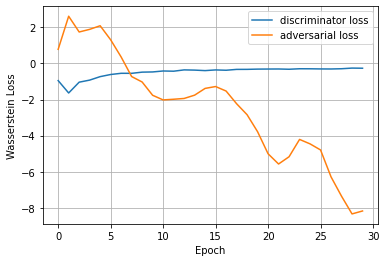

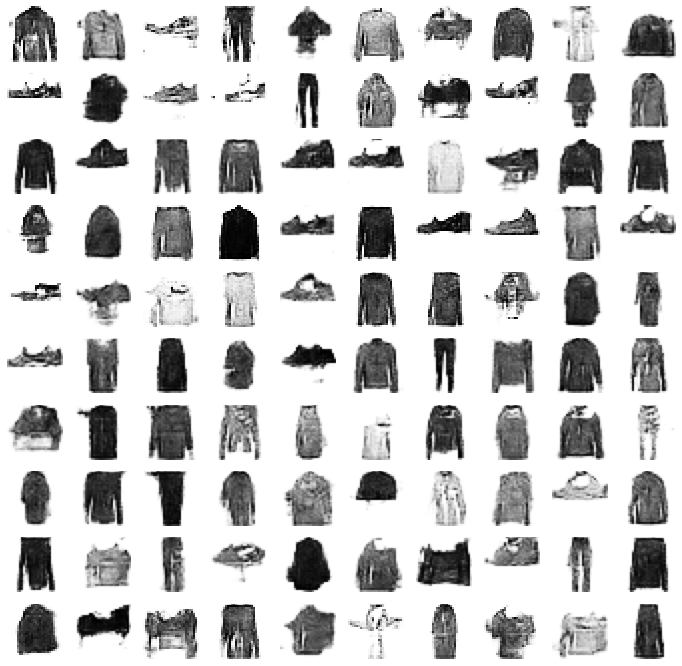

In [42]:
plot_Wloss(history)
gen_images = generator(get_noise(100, 128))
show_plot(gen_images, 10)

Build the GAN model with building blocks

In [ ]:
def conv_block(x, filters, activation, kernel_size=(3, 3), strides=(1, 1), padding="same", use_bias=True, use_bn=False, use_dropout=False, drop_value=0.4):
  x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)
  if use_bn:
    x = layers.BatchNormalization()(x)
  x = activation(x)
  if use_dropout:
    x = layers.Dropout(drop_value)(x)
  return x

In [ ]:
def get_discriminator_model(img_shape=(28,28,1)):
  img_input = layers.Input(shape=img_shape)
  # Zero pad the input to make the input images size to (32, 32, 1).
  x = layers.ZeroPadding2D(padding=(2,2))(img_input)
  x = conv_block(x=x, filters=64, activation=layers.LeakyReLU(0.2), kernel_size=(5,5), strides=(2,2), use_bias=True, use_bn=False, use_dropout=False)
  x = conv_block(x=x, filters=128, activation=layers.LeakyReLU(0.2), kernel_size=(5,5), strides=(2,2), use_bias=True, use_bn=False, use_dropout=True, drop_value=0.3)
  x = conv_block(x=x, filters=256, activation=layers.LeakyReLU(0.2), kernel_size=(5,5), strides=(2,2), use_bias=True, use_bn=False, use_dropout=True, drop_value=0.3)
  x = conv_block(x=x, filters=512, activation=layers.LeakyReLU(0.2), kernel_size=(5,5), strides=(2,2), use_bias=True, use_bn=False, use_dropout=False, drop_value=0.3)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(1)(x)

  # set the inputs and outputs of the model
  d_model = tf.keras.Model(inputs=img_input, outputs=x, name="discriminator")
  return d_model

In [ ]:
d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        1664      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)       

In [ ]:
def upsample_block(x, filters, activation, kernel_size=(3, 3), strides=(1, 1), up_size=(2, 2), padding="same", use_bn=False, use_bias=True, use_dropout=False, drop_value=0.3):
  # the UpSampleing2D repeats and output the same pixel twice
  x = layers.UpSampling2D(up_size)(x)
  x = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)
  if use_bn:
    x = layers.BatchNormalization()(x)
  if activation:
    x = activation(x)
  if use_dropout:
    x = layers.Dropout(drop_value)(x)

  return x

In [ ]:
def get_generator_model(noise_dim):
  # input a 128 dimension random noise
  # reshape into 4*4*256
  noise = layers.Input(shape=(noise_dim,))
  x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.2)(x)
  x = layers.Reshape((4, 4, 256))(x)

  # use the UpSampling2D instead of Conv2DTranspose
  x = upsample_block(x=x, filters=128, activation=layers.LeakyReLU(0.2), strides=(1,1), use_bias=False, use_bn=True, padding="same")
  x = upsample_block(x=x, filters=64, activation=layers.LeakyReLU(0.2), strides=(1,1), use_bias=False, use_bn=True, padding="same")
  # reshape to 32*32*1
  x = upsample_block(x=x, filters=1, activation=layers.Activation("tanh"), strides=(1,1), use_bias=False, use_bn=True, padding="same")
  # crop to 28*28*1
  x = layers.Cropping2D((2,2))(x)

  # define inputs and outputs
  g_model = tf.keras.Model(inputs=noise, outputs=x, name="generator")
  return g_model

In [ ]:
g_model = get_generator_model(noise_dim=128)
g_model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              524288    
_________________________________________________________________
batch_normalization_4 (Batch (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 128)         29

In [ ]:
# define the optimizer
d_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
g_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
@tf.function
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

# Define the loss functions for the generator.
# minimize the inverted == maximize
@tf.function
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# define the Gradient Penalty
@tf.function
def gradient_penalty(batch_size, real_images, fake_images, discriminator):
  # use an interpolated image to add to the discriminator loss

  # Get the interpolated image
  # alpha = tf.random.normal(shape=[batch_size,1,1,1], mean=0.0, stddev=1.0)
  epsilon = tf.random.normal(shape=[batch_size,1,1,1], mean=0.0, stddev=1.0)
  diff = fake_images - real_images
  interpolated = real_images + epsilon * diff
  # mixed_images = real_images * epsilon + fake_images * (1.0 - epsilon)

  # compute the gradient of critic(mixed_images)
  with tf.GradientTape() as gp_tape:
    gp_tape.watch(interpolated)
    # 1. Get the discriminator output for this interpolated image.
    pred = discriminator(interpolated, training=True)

  # 2. Calculate the gradients w.r.t to this interpolated image.
  grads = gp_tape.gradient(pred, interpolated)
  # 3. Calculate the norm of the gradients.
  # the reduce sum preserve the batch size -- each image has a norm
  norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
  # get the gradient penalty - substract by 1 so that the penalty always least than 1
  gradient_penalty = tf.reduce_mean((norm - 1.0) ** 2)
  return gradient_penalty


@tf.function
def train_step(real_images, Lambda=10.0, d_extra_step=3):
  batch_size = real_images.shape[0]
  # 1. Train the discriminator (critic) and get the discriminator loss for 3 steps
  # 2. Train the generator and get the generator loss for 1 step
  # 3. Calculate the gradient penalty (GP)
  # 4. Multiply this gradient penalty with a constant weight factor Lambda then 
  # sum to the discriminator loss to get the critic loss
  # 6. Return the generator and discriminator losses as a loss dictionary

  # Train the critic
  for i in range(d_extra_step):
    # Sample random points in the latent space
    z_input = tf.random.normal(shape=(batch_size, 128))      
    with tf.GradientTape() as tape:
      # Decode them to fake images
      generated_images = g_model(z_input, training=True)
      fake_logits = d_model(generated_images, training=True)
      real_logits = d_model(real_images, training=True)
      # compute the discriminator loss using the fake and real image logit
      d_cost = discriminator_loss(real_img=real_logits, fake_img=fake_logits)
      # compute gradient penalty
      gp = gradient_penalty(batch_size=real_images.shape[0], real_images=real_images, fake_images=generated_images, discriminator=d_model)
      # add the gradient penalty to the discriminator loss
      d_loss = d_cost + gp * Lambda
      # compute the gradient based on the total discriminator loss and the discriminator
    d_gradient = tape.gradient(d_loss, d_model.trainable_weights)
    # update the discriminator
    d_optimizer.apply_gradients(zip(d_gradient, d_model.trainable_weights))

  # Train the generator
  z_input = tf.random.normal(shape=(batch_size, 128)) 
  with tf.GradientTape() as tape:
    generated_images = g_model(z_input, training=True)
    # Get the discriminator logits for fake images
    gen_img_logits = d_model(generated_images, training=True)
    # Calculate the generator loss
    g_loss = generator_loss(fake_img=gen_img_logits)
  # get the gradient of the generator loss
  g_gradient = tape.gradient(g_loss, g_model.trainable_weights)
  # update the generator
  g_optimizer.apply_gradients(zip(g_gradient, g_model.trainable_weights))

  return d_loss, g_loss, generated_images

In [ ]:
def load_digits(batch_size=256):
  (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
  all_digits = np.concatenate([x_train, x_test])
  all_digits = all_digits.astype("float32") 
  all_digits = (all_digits-127.5) / 127.5
  all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
  dataset = tf.data.Dataset.from_tensor_slices(all_digits)
  dataset = dataset.shuffle(buffer_size=batch_size).prefetch(buffer_size=batch_size).batch(batch_size)
  return dataset

In [ ]:
from tensorflow.keras.datasets.fashion_mnist import load_data

def get_fashion(batch_size=512):
  (trainX, trainy), (testX, testy) = load_data()
  all_fashions = np.concatenate([trainX, testX])
  all_fashions = all_fashions.astype("float32")
  all_fashions = (all_fashions - 127.5) / 127.5
  all_fashions = np.reshape(all_fashions, (-1, 28, 28, 1))
  dataset = tf.data.Dataset.from_tensor_slices(all_fashions)
  dataset = dataset.shuffle(buffer_size=batch_size).prefetch(buffer_size=batch_size).batch(batch_size)
  return dataset

In [ ]:
if not os.path.exists('syn_images'):
  folder = os.mkdir('syn_images')

epochs = 30  # In practice you need at least 20 epochs to generate nice images
save_dir = './syn_images'
history = {}
history['d_loss'] = []
history['g_loss'] = []

dataset = load_digits()
for epoch in range(epochs):
    print("\nStart epoch", epoch)
    d_loss_list = []
    g_loss_list = []
    for step, real_images in enumerate(dataset):
      d_loss, g_loss, generated_images = train_step(real_images)
      d_loss_list.append(d_loss)
      g_loss_list.append(g_loss)
      
      if step % 100 == 0:
        print("discriminator loss at step %d: %.2f" % (step, d_loss))
        print("adversarial loss at step %d: %.2f" % (step, g_loss))

        # Save one generated image
        img = tf.keras.preprocessing.image.array_to_img((generated_images[0]*127.5+127.5), scale=False)
        img.save(os.path.join(save_dir, "generated_img" + str(step) + ".png"))
    
    print("------End of epoch: {epoch}------")
    mean_d_loss = np.array(d_loss_list).mean()
    mean_g_loss = np.array(g_loss_list).mean()
    history['d_loss'].append(mean_d_loss)
    history['g_loss'].append(mean_g_loss)
    print("discriminator loss at epoch %d: %.2f" % (epoch, mean_d_loss))
    print("adversarial loss at epoch %d: %.2f" % (epoch, mean_g_loss))



Start epoch 0
discriminator loss at step 0: -0.21
adversarial loss at step 0: 18.98
discriminator loss at step 100: 0.59
adversarial loss at step 100: 1.48
discriminator loss at step 200: -2.89
adversarial loss at step 200: 14.66
------End of epoch: {epoch}------
discriminator loss at epoch 0: -1.33
adversarial loss at epoch 0: 10.05

Start epoch 1
discriminator loss at step 0: -0.58
adversarial loss at step 0: 17.40
discriminator loss at step 100: -1.44
adversarial loss at step 100: 9.01
discriminator loss at step 200: -2.73
adversarial loss at step 200: 11.16
------End of epoch: {epoch}------
discriminator loss at epoch 1: -1.46
adversarial loss at epoch 1: 11.10

Start epoch 2
discriminator loss at step 0: 0.55
adversarial loss at step 0: 13.93
discriminator loss at step 100: -2.79
adversarial loss at step 100: 11.65
discriminator loss at step 200: -0.27
adversarial loss at step 200: 6.55
------End of epoch: {epoch}------
discriminator loss at epoch 2: -1.33
adversarial loss at epo

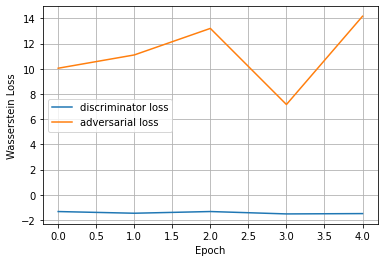

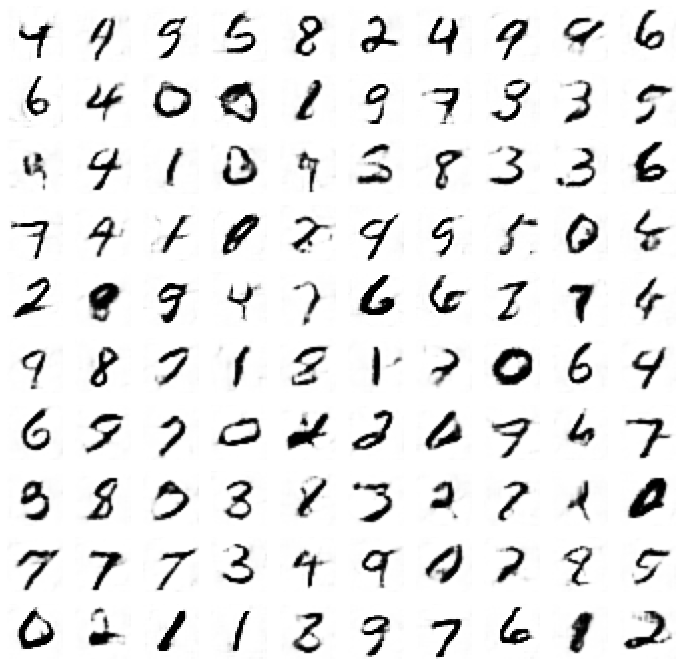

In [ ]:
def plot_Wloss(history):
  plt.plot(history['d_loss'], label='discriminator loss')
  plt.plot(history['g_loss'], label='adversarial loss')
  # plt.ylim([0, 1.5])
  plt.xlabel('Epoch')
  plt.ylabel('Wasserstein Loss')
  plt.legend()
  plt.grid(True)

def get_noise(n_sample, latent_dim):
  return tf.random.normal(shape=(n_sample, latent_dim))

def show_plot(examples, n):
  plt.figure(figsize=(12,12))
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis(False)
    # plt.tight_layout(True)
    plt.imshow(examples[i, :, :, 0], cmap='gray_r')
  plt.show()

plot_Wloss(history)
gen_images = g_model(get_noise(100, 128))
show_plot(gen_images, 10)

Conditional GAN -- use an embedding layer concatinate with the input image

In [4]:
# define the convolutional block
def conv_block(x, filters, activation, kernel_size=(3, 3), strides=(1, 1), padding="same", use_bias=True, use_bn=False, use_dropout=False, drop_value=0.4):
  x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)
  if use_bn:
    x = layers.BatchNormalization()(x)
  x = activation(x)
  if use_dropout:
    x = layers.Dropout(drop_value)(x)
  return x

# define the upsample block
def upsample_block(x, filters, activation, kernel_size=(3, 3), strides=(1, 1), up_size=(2, 2), padding="same", use_bn=False, use_bias=True, use_dropout=False, drop_value=0.3):
  # the UpSampleing2D repeats and output the same pixel twice
  x = layers.UpSampling2D(up_size)(x)
  x = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)
  if use_bn:
    x = layers.BatchNormalization()(x)
  if activation:
    x = activation(x)
  if use_dropout:
    x = layers.Dropout(drop_value)(x)
  return x

In [45]:
from keras.datasets.fashion_mnist import load_data

def get_fashion_label(batch_size=512):
  (trainX, trainy), (testX, testy) = load_data()
  all_data = np.concatenate([trainX, testX])
  all_data = all_data.astype("float32")
  all_data = (all_data - 127.5) / 127.5
  all_data = np.reshape(all_data, (-1, 28, 28, 1))
  all_labels = np.concatenate([trainy, testy])
  all_labels = all_labels.astype('float32')
  all_labels = tf.one_hot(all_labels,10)
  dataset = tf.data.Dataset.from_tensor_slices((all_data, all_labels))
  dataset = dataset.shuffle(buffer_size=batch_size).prefetch(buffer_size=batch_size).batch(batch_size)
  return dataset


In [46]:
if not os.path.exists('syn_images'):
  folder = os.mkdir('syn_images')

label_names = ["t-shirt", "trousers", "pullover", "dress skirt", "coat", "sandals", "shirt", "sneakers", "bag", "ankle boots"]
dataset = get_fashion_label()
images, image_labels = next(iter(dataset))
print(images.shape)
print(image_labels.shape)
image_labels[:5]

(512, 28, 28, 1)
(512, 10)


<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>

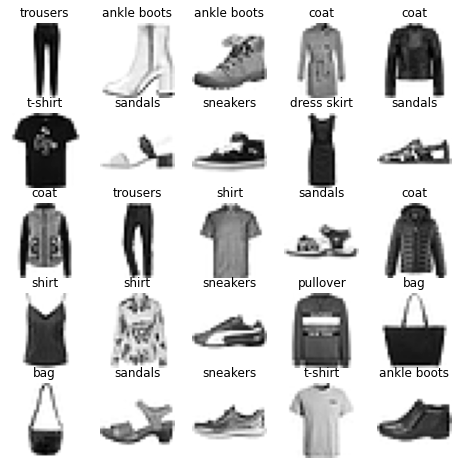

In [47]:
def show_plot_label(examples, labels, n):
  plt.figure(figsize=(8,8))
  label_names = ["t-shirt", "trousers", "pullover", "dress skirt", "coat", "sandals", "shirt", "sneakers", "bag", "ankle boots"]
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis(False)
    label_idx = np.argmax(image_labels[i])
    plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.title(label_names[label_idx])
  plt.show()

show_plot_label(images, image_labels, 5)

In [49]:
z_input = tf.random.normal(shape=(512, 128))
combined = tf.concat([z_input, image_labels], axis=1)
combined.shape

TensorShape([512, 138])

In [50]:
def get_input_dimensions(z_dim, mnist_shape, n_classes):
  # get the size of the conditional input dimensions
  # from z_dim, the image shape(H*W*C), and number of classes.
  generator_input_dim = z_dim + n_classes
  discriminator_im_chan = mnist_shape[2] + n_classes
  return generator_input_dim, discriminator_im_chan

In [51]:
gen_input_dim, disc_input_chan = get_input_dimensions(128, (28,28,1), 10)
print(gen_input_dim)
print(disc_input_chan)

138
11


In [52]:
def get_discriminator_model(img_shape=(28,28,11)):
  img_input = layers.Input(shape=img_shape)
  # Zero pad the input to make the input images size to (32, 32, input_chan).
  x = layers.ZeroPadding2D(padding=(2,2))(img_input)
  x = conv_block(x=x, filters=64, activation=layers.LeakyReLU(0.2), kernel_size=(5,5), strides=(2,2), use_bias=True, use_bn=False, use_dropout=False)
  x = conv_block(x=x, filters=128, activation=layers.LeakyReLU(0.2), kernel_size=(5,5), strides=(2,2), use_bias=True, use_bn=False, use_dropout=True, drop_value=0.3)
  x = conv_block(x=x, filters=256, activation=layers.LeakyReLU(0.2), kernel_size=(5,5), strides=(2,2), use_bias=True, use_bn=False, use_dropout=True, drop_value=0.3)
  x = conv_block(x=x, filters=512, activation=layers.LeakyReLU(0.2), kernel_size=(5,5), strides=(2,2), use_bias=True, use_bn=False, use_dropout=False, drop_value=0.3)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(1)(x)

  # set the inputs and outputs of the model
  d_model = tf.keras.Model(inputs=img_input, outputs=x, name="discriminator")
  return d_model

In [53]:
def get_generator_model(noise_dim=128):
  # input a random noise random_dim + label one-hot
  # reshape into 4*4*256
  noise = layers.Input(shape=(noise_dim,))
  x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.2)(x)
  x = layers.Reshape((4, 4, 256))(x)

  # use the UpSampling2D instead of Conv2DTranspose
  x = upsample_block(x=x, filters=128, activation=layers.LeakyReLU(0.2), strides=(1,1), use_bias=False, use_bn=True, padding="same")
  x = upsample_block(x=x, filters=64, activation=layers.LeakyReLU(0.2), strides=(1,1), use_bias=False, use_bn=True, padding="same")
  # reshape to 32*32*1
  x = upsample_block(x=x, filters=1, activation=layers.Activation("tanh"), strides=(1,1), use_bias=False, use_bn=True, padding="same")
  # crop to 28*28*1
  x = layers.Cropping2D((2,2))(x)

  # define inputs and outputs
  g_model = tf.keras.Model(inputs=noise, outputs=x, name="generator")
  return g_model

In [54]:
d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 28, 28, 11)]      0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 32, 32, 11)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 64)        17664     
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 128)       

In [55]:
g_model = get_generator_model(138)
g_model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 138)]             0         
_________________________________________________________________
dense_14 (Dense)             (None, 4096)              565248    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 128)         29

In [56]:
# Instantiate one optimizer for the discriminator and another for the generator.
d_optimizer = keras.optimizers.Adam(learning_rate=0.0002)
g_optimizer = keras.optimizers.Adam(learning_rate=0.0002)

# Use a Binary Cross-Entropy (BCE) loss function.
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)


@tf.function
def train_step(data_batch):
  real_images, image_labels = data_batch
  batch_size = real_images.shape[0]
  z_input = tf.random.normal(shape=(batch_size, 128))
  z_input_and_label = tf.concat([z_input,image_labels], axis=1)
  generated_images = g_model(z_input_and_label)
  image_one_hot_labels = image_labels[:,None, None,:] # batch_size*1*1*10
  image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=28*28) # create all the dimensions in order to reshape
  # batch_size * 28 * 28* 10 -- as the encoded labels 
  image_one_hot_labels = tf.reshape(image_one_hot_labels, shape=(batch_size, real_images.shape[1], real_images.shape[2], image_labels.shape[1]))

  fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], axis=3)
  real_image_and_labels = tf.concat([real_images, image_one_hot_labels], axis=3)
  combined_images_and_labels = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)
  labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
  labels += 0.05 * tf.random.uniform(labels.shape)

  # Train the discriminator
  with tf.GradientTape() as tape:
    tape.watch(combined_images_and_labels)
    predictions = d_model(combined_images_and_labels)
    d_loss = loss_fn(labels, predictions)
  grads = tape.gradient(d_loss, d_model.trainable_weights)
  d_optimizer.apply_gradients(zip(grads, d_model.trainable_weights))

  # Sample random points in the latent space
  z_input = tf.random.normal(shape=(batch_size, 128))
  z_input_and_label = tf.concat([z_input,image_labels], axis=1)
  misleading_labels = tf.zeros((batch_size, 1))

  # Train the generator (note that we should *not* update the weights of the discriminator)!
  with tf.GradientTape() as tape:
    tape.watch(z_input_and_label)
    gen_imgs = g_model(z_input_and_label)
    fake_image_and_labels = tf.concat([gen_imgs, image_one_hot_labels], axis=3)
    predictions = d_model(fake_image_and_labels)
    g_loss = loss_fn(misleading_labels, predictions)
  grads = tape.gradient(g_loss, g_model.trainable_weights)
  g_optimizer.apply_gradients(zip(grads, g_model.trainable_weights))
  return d_loss, g_loss, generated_images

In [57]:
# if not os.path.exists('syn_images'):
#   folder = os.mkdir('syn_images')

epochs = 30  # In practice you need at least 20 epochs to generate nice digits.
save_dir = './syn_images'
history = {}
history['d_loss'] = []
history['g_loss'] = []
# total_step = total_step
for epoch in range(epochs):
    print("\nStart epoch", epoch)
    d_loss_list = []
    g_loss_list = []


    for step, data_batch in enumerate(dataset):
        # Train the discriminator & generator on one batch of real images.
        d_loss, g_loss, generated_images = train_step(data_batch)
        d_loss_list.append(d_loss)
        g_loss_list.append(g_loss)

        # Logging.
        if step % 100 == 0:
            # Print metrics
            print("discriminator loss at step %d: %.2f" % (step, d_loss))
            print("adversarial loss at step %d: %.2f" % (step, g_loss))

            # Save one generated image
            img = tf.keras.preprocessing.image.array_to_img(
                (generated_images[0] * 255.0), scale=False
            )
            img.save(os.path.join(save_dir, "generated_img" + str(step) + ".png"))
    
    print("------End of epoch: {epoch}------")
    mean_d_loss = np.array(d_loss_list).mean()
    mean_g_loss = np.array(g_loss_list).mean()
    history['d_loss'].append(mean_d_loss)
    history['g_loss'].append(mean_g_loss)
    print("discriminator loss at epoch %d: %.2f" % (epoch, mean_d_loss))
    print("adversarial loss at epoch %d: %.2f" % (epoch, mean_g_loss))


Start epoch 0
discriminator loss at step 0: 0.69
adversarial loss at step 0: 0.68
discriminator loss at step 100: 0.76
adversarial loss at step 100: 1.16
------End of epoch: {epoch}------
discriminator loss at epoch 0: 0.50
adversarial loss at epoch 0: 2.47

Start epoch 1
discriminator loss at step 0: 0.45
adversarial loss at step 0: 1.37
discriminator loss at step 100: 0.08
adversarial loss at step 100: 5.12
------End of epoch: {epoch}------
discriminator loss at epoch 1: 0.23
adversarial loss at epoch 1: 3.48

Start epoch 2
discriminator loss at step 0: 0.56
adversarial loss at step 0: 2.71
discriminator loss at step 100: 0.24
adversarial loss at step 100: 3.53
------End of epoch: {epoch}------
discriminator loss at epoch 2: 0.28
adversarial loss at epoch 2: 3.74

Start epoch 3
discriminator loss at step 0: 0.17
adversarial loss at step 0: 4.91
discriminator loss at step 100: 0.18
adversarial loss at step 100: 6.36
------End of epoch: {epoch}------
discriminator loss at epoch 3: 0.1

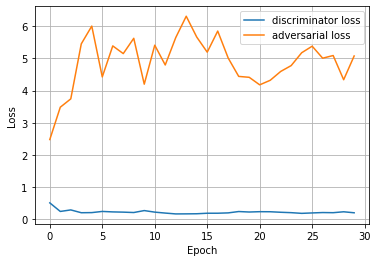

In [59]:
def plot_loss(history):
  plt.plot(history['d_loss'], label='discriminator loss')
  plt.plot(history['g_loss'], label='adversarial loss')
  # plt.ylim([0, 1.5])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [60]:
def gen_samples(n, g_model=g_model):
  sample_labels = np.random.randint(low=0, high=9, size=n*n)
  sample_labels = tf.convert_to_tensor(sample_labels)
  one_hot_labels = tf.one_hot(sample_labels, 10)
  z_input = tf.random.normal(shape=(n*n, 128))
  z_input_and_label = tf.concat([z_input,one_hot_labels], axis=1)
  gen_images = g_model(z_input_and_label)
  return gen_images, one_hot_labels

In [61]:
gen_images, labels = gen_samples(5)

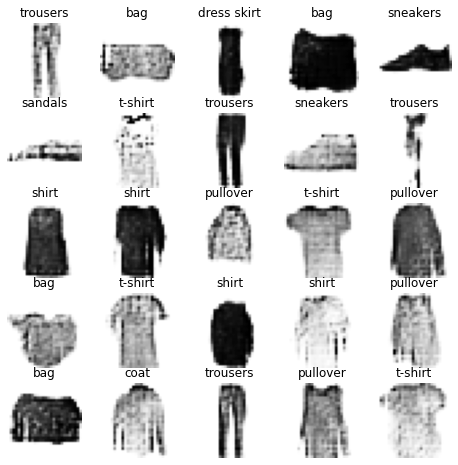

In [62]:
def show_samples(n, images, labels, label_names):
  plt.figure(figsize=(8,8))
  label_idx = np.argmax(labels, axis=1)
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis(False)
    plt.imshow(images[i, :, :, 0], cmap='gray_r')
    plt.title(label_names[label_idx[i]])
  plt.show()

label_names = ['t-shirt','trousers','pullover','dress skirt','coat','sandals','shirt','sneakers','bag','ankle boots']
show_samples(5, gen_images, labels, label_names)

Train the conditional GAN using the Wasserstein Loss

In [63]:
dataset = get_fashion_label(512)
images, image_labels = next(iter(dataset))
print(images.shape)
print(image_labels.shape)
image_labels[:5]

(512, 28, 28, 1)
(512, 10)


<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)>

In [66]:
d_model = get_discriminator_model()
g_model = get_generator_model(138)
d_model.summary()
g_model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 28, 28, 11)]      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 32, 32, 11)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 16, 16, 64)        17664     
_________________________________________________________________
leaky_re_lu_55 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 8, 8, 128)       

In [67]:
# define the optimizer
d_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
g_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
@tf.function
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

# Define the loss functions for the generator.
# minimize the inverted == maximize
@tf.function
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# define the Gradient Penalty
@tf.function
def gradient_penalty(batch_size, real_images, fake_images, one_hot_labels, discriminator):
  # use an interpolated image to add to the discriminator loss

  # Get the interpolated image
  # alpha = tf.random.normal(shape=[batch_size,1,1,1], mean=0.0, stddev=1.0)
  epsilon = tf.random.normal(shape=[batch_size,1,1,1], mean=0.0, stddev=1.0)
  diff = fake_images - real_images
  interpolated = real_images + epsilon * diff
  interpolated_and_labels = tf.concat([interpolated, one_hot_labels], axis=3)
  # mixed_images = real_images * epsilon + fake_images * (1.0 - epsilon)

  # compute the gradient of critic(mixed_images)
  with tf.GradientTape() as gp_tape:
    gp_tape.watch(interpolated_and_labels)
    # 1. Get the discriminator output for this interpolated image.
    pred = discriminator(interpolated_and_labels, training=True)

  # 2. Calculate the gradients w.r.t to this interpolated image.
  grads = gp_tape.gradient(pred, interpolated_and_labels)
  # 3. Calculate the norm of the gradients.
  # the reduce sum preserve the batch size -- each image has a norm
  norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
  # get the gradient penalty - substract by 1 so that the penalty always least than 1
  gradient_penalty = tf.reduce_mean((norm - 1.0) ** 2)
  return gradient_penalty

In [68]:
@tf.function
def train_step(data_batch, Lambda=10.0, d_extra_step=3):
  real_images, image_labels = data_batch
  batch_size = real_images.shape[0]
  # 1. Train the discriminator (critic) and get the discriminator loss for 3 steps
  # 2. Train the generator and get the generator loss for 1 step
  # 3. Calculate the gradient penalty (GP)
  # 4. Multiply this gradient penalty with a constant weight factor Lambda then 
  # sum to the discriminator loss to get the critic loss
  # 6. Return the generator and discriminator losses as a loss dictionary

  # Train the critic
  for i in range(d_extra_step):
    # Sample random points in the latent space
    z_input = tf.random.normal(shape=(batch_size, 128))
    z_input_and_label = tf.concat([z_input,image_labels], axis=1)
    # generated_images = g_model(z_input_and_label)
    image_one_hot_labels = image_labels[:,None, None,:] # batch_size*1*1*10
    image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=28*28) # create all the dimensions in order to reshape
    # batch_size * 28 * 28* 10 -- as the encoded labels
    image_one_hot_labels = tf.reshape(image_one_hot_labels, shape=(batch_size, real_images.shape[1], real_images.shape[2], image_labels.shape[1]))

    with tf.GradientTape() as tape:
      # Decode them to fake images
      generated_images = g_model(z_input_and_label, training=True)
      fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], axis=3)
      fake_logits = d_model(fake_image_and_labels, training=True)
      real_image_and_labels = tf.concat([real_images, image_one_hot_labels], axis=3)
      real_logits = d_model(real_image_and_labels, training=True)

      # compute the discriminator loss using the fake and real image logit
      d_cost = discriminator_loss(real_img=real_logits, fake_img=fake_logits)
      # compute gradient penalty
      gp = gradient_penalty(batch_size=real_images.shape[0], real_images=real_images, fake_images=generated_images, one_hot_labels=image_one_hot_labels, discriminator=d_model)
      # add the gradient penalty to the discriminator loss
      d_loss = d_cost + gp * Lambda
      # compute the gradient based on the total discriminator loss and the discriminator
    d_gradient = tape.gradient(d_loss, d_model.trainable_weights)
    # update the discriminator
    d_optimizer.apply_gradients(zip(d_gradient, d_model.trainable_weights))

  # Train the generator
  z_input = tf.random.normal(shape=(batch_size, 128))
  z_input_and_label = tf.concat([z_input,image_labels], axis=1)
  with tf.GradientTape() as tape:
    generated_images = g_model(z_input_and_label, training=True)
    # Get the discriminator logits for fake images
    gen_image_and_labels = tf.concat([generated_images, image_one_hot_labels], axis=3)
    gen_img_logits = d_model(gen_image_and_labels, training=True)
    # Calculate the generator loss
    g_loss = generator_loss(fake_img=gen_img_logits)
  # get the gradient of the generator loss
  g_gradient = tape.gradient(g_loss, g_model.trainable_weights)
  # update the generator
  g_optimizer.apply_gradients(zip(g_gradient, g_model.trainable_weights))

  return d_loss, g_loss, generated_images

In [69]:
epochs = 30  # In practice you need at least 20 epochs to generate nice digits.
save_dir = './syn_images'
history = {}
history['d_loss'] = []
history['g_loss'] = []
# total_step = total_step
for epoch in range(epochs):
    print("\nStart epoch", epoch)
    d_loss_list = []
    g_loss_list = []


    for step, data_batch in enumerate(dataset):
        # Train the discriminator & generator on one batch of real images.
        d_loss, g_loss, generated_images = train_step(data_batch)
        d_loss_list.append(d_loss)
        g_loss_list.append(g_loss)

        # Logging.
        if step % 100 == 0:
            # Print metrics
            print("discriminator loss at step %d: %.2f" % (step, d_loss))
            print("adversarial loss at step %d: %.2f" % (step, g_loss))

            # Save one generated image
            img = tf.keras.preprocessing.image.array_to_img(
                (generated_images[0] * 255.0), scale=False
            )
            img.save(os.path.join(save_dir, "generated_img" + str(step) + ".png"))
    
    print("------End of epoch: {epoch}------")
    mean_d_loss = np.array(d_loss_list).mean()
    mean_g_loss = np.array(g_loss_list).mean()
    history['d_loss'].append(mean_d_loss)
    history['g_loss'].append(mean_g_loss)
    print("discriminator loss at epoch %d: %.2f" % (epoch, mean_d_loss))
    print("adversarial loss at epoch %d: %.2f" % (epoch, mean_g_loss))


Start epoch 0
discriminator loss at step 0: 6.15
adversarial loss at step 0: -0.08
discriminator loss at step 100: -6.82
adversarial loss at step 100: -18.21
------End of epoch: {epoch}------
discriminator loss at epoch 0: -7.17
adversarial loss at epoch 0: -16.57

Start epoch 1
discriminator loss at step 0: -6.89
adversarial loss at step 0: -17.52
discriminator loss at step 100: -6.69
adversarial loss at step 100: -16.48
------End of epoch: {epoch}------
discriminator loss at epoch 1: -6.82
adversarial loss at epoch 1: -15.65

Start epoch 2
discriminator loss at step 0: -6.79
adversarial loss at step 0: -14.50
discriminator loss at step 100: -6.28
adversarial loss at step 100: -5.93
------End of epoch: {epoch}------
discriminator loss at epoch 2: -6.36
adversarial loss at epoch 2: -9.97

Start epoch 3
discriminator loss at step 0: -6.06
adversarial loss at step 0: -2.98
discriminator loss at step 100: -5.44
adversarial loss at step 100: -2.84
------End of epoch: {epoch}------
discrim

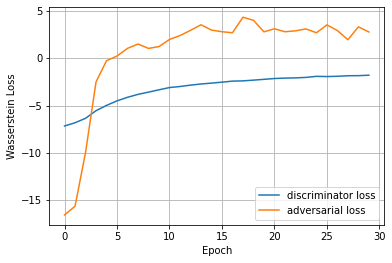

In [72]:
plot_Wloss(history)

In [70]:
def gen_samples(n, g_model=g_model):
  sample_labels = np.random.randint(low=0, high=9, size=n*n)
  sample_labels = tf.convert_to_tensor(sample_labels)
  one_hot_labels = tf.one_hot(sample_labels, 10)
  z_input = tf.random.normal(shape=(n*n, 128))
  z_input_and_label = tf.concat([z_input,one_hot_labels], axis=1)
  gen_images = g_model(z_input_and_label)
  return gen_images, one_hot_labels

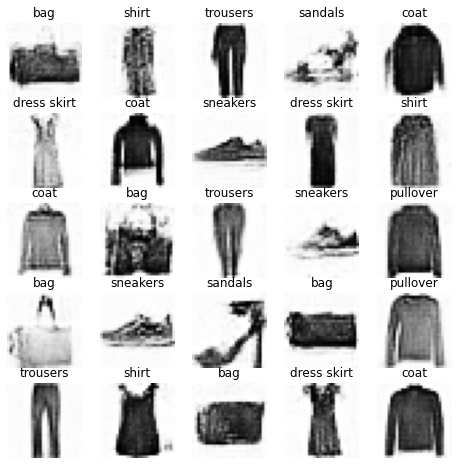

In [71]:
gen_images, labels = gen_samples(5)
def show_samples(n, images, labels, label_names):
  plt.figure(figsize=(8,8))
  label_idx = np.argmax(labels, axis=1)
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis(False)
    plt.imshow(images[i, :, :, 0], cmap='gray_r')
    plt.title(label_names[label_idx[i]])
  plt.show()

label_names = ['t-shirt','trousers','pullover','dress skirt','coat','sandals','shirt','sneakers','bag','ankle boots']
show_samples(5, gen_images, labels, label_names)

Define the GAN with simple label (categorical) input

In [5]:
# define the convolutional block
def conv_block(x, filters, activation, kernel_size=(3, 3), strides=(1, 1), padding="same", use_bias=True, use_bn=False, use_dropout=False, drop_value=0.4):
  x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)
  if use_bn:
    x = layers.BatchNormalization()(x)
  x = activation(x)
  if use_dropout:
    x = layers.Dropout(drop_value)(x)
  return x

# define the upsample block
def upsample_block(x, filters, activation, kernel_size=(3, 3), strides=(1, 1), up_size=(2, 2), padding="same", use_bn=False, use_bias=True, use_dropout=False, drop_value=0.3):
  # the UpSampleing2D repeats and output the same pixel twice
  x = layers.UpSampling2D(up_size)(x)
  x = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)
  if use_bn:
    x = layers.BatchNormalization()(x)
  if activation:
    x = activation(x)
  if use_dropout:
    x = layers.Dropout(drop_value)(x)
  return x

In [6]:
def get_discriminator_model(img_shape=(28,28,1), n_classes=10):
  label_input = layers.Input(shape=(1,))
  label_layer = layers.Embedding(10, 50)(label_input)
  label_layer = layers.Dense(28*28*1)(label_layer)
  label_layer = layers.Reshape((28,28,1))(label_layer)

  img_input = layers.Input(shape=img_shape)
  merged_layer = layers.concatenate([img_input, label_layer], axis=3) # 28*28*4
  # Zero pad the input to make the input images size to (32, 32, input_chan).
  x = layers.ZeroPadding2D(padding=(2,2))(merged_layer)
  x = conv_block(x=x, filters=64, activation=layers.LeakyReLU(0.2), kernel_size=(5,5), strides=(2,2), use_bias=True, use_bn=False, use_dropout=False)
  x = conv_block(x=x, filters=128, activation=layers.LeakyReLU(0.2), kernel_size=(5,5), strides=(2,2), use_bias=True, use_bn=False, use_dropout=True, drop_value=0.3)
  x = conv_block(x=x, filters=256, activation=layers.LeakyReLU(0.2), kernel_size=(5,5), strides=(2,2), use_bias=True, use_bn=False, use_dropout=True, drop_value=0.3)
  x = conv_block(x=x, filters=512, activation=layers.LeakyReLU(0.2), kernel_size=(5,5), strides=(2,2), use_bias=True, use_bn=False, use_dropout=False, drop_value=0.3)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(1)(x)

  # set the inputs and outputs of the model
  d_model = tf.keras.Model(inputs=[img_input, label_input], outputs=x, name="discriminator")
  return d_model

In [7]:
# the dicrimininator only needs one extra channel
d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_3[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1, 784)       39984       embedding_1[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________________

In [8]:
def get_generator_model(noise_dim=128, n_classes=10):
  # input a random noise random_dim + label one-hot
  # reshape into 4*4*256
  label_input = layers.Input(shape=(1,))
  label_layer = layers.Embedding(n_classes, 50)(label_input)
  label_layer = layers.Dense(4*4*1)(label_layer)
  label_layer = layers.Reshape((4,4,1))(label_layer)

  noise = layers.Input(shape=(noise_dim,))
  x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.2)(x)
  x = layers.Reshape((4, 4, 256))(x)

  x = layers.Concatenate()([x, label_layer])

  # use the UpSampling2D instead of Conv2DTranspose
  x = upsample_block(x=x, filters=128, activation=layers.LeakyReLU(0.2), strides=(1,1), use_bias=False, use_bn=True, padding="same")
  x = upsample_block(x=x, filters=64, activation=layers.LeakyReLU(0.2), strides=(1,1), use_bias=False, use_bn=True, padding="same")
  # reshape to 32*32*1
  x = upsample_block(x=x, filters=1, activation=layers.Activation("tanh"), strides=(1,1), use_bias=False, use_bn=True, padding="same")
  # crop to 28*28*1
  x = layers.Cropping2D((2,2))(x)
  # define inputs and outputs
  g_model = tf.keras.Model(inputs=[noise, label_input], outputs=x, name="generator")
  return g_model

In [9]:
g_model = get_generator_model()
g_model.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 4096)         524288      input_6[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 4096)         16384       dense_4[0][0]                    
__________________________________________________________________________________________

In [10]:
from keras.datasets.fashion_mnist import load_data

def get_fashion_label(batch_size=256):
  (trainX, trainy), (testX, testy) = load_data()
  all_data = np.concatenate([trainX, testX])
  all_data = all_data.astype("float32")
  all_data = (all_data - 127.5) / 127.5
  all_data = np.reshape(all_data, (-1, 28, 28, 1))
  all_labels = np.concatenate([trainy, testy])
  all_labels = all_labels.astype('float32')
  dataset = tf.data.Dataset.from_tensor_slices((all_data, all_labels))
  dataset = dataset.shuffle(buffer_size=batch_size).prefetch(buffer_size=batch_size).batch(batch_size)
  return dataset

In [11]:
if not os.path.exists('syn_images'):
  folder = os.mkdir('syn_images')

label_names = ["t-shirt", "trousers", "pullover", "dress skirt", "coat", "sandals", "shirt", "sneakers", "bag", "ankle boots"]
dataset = get_fashion_label()
images, image_labels = next(iter(dataset))
print(images.shape)
print(image_labels.shape)
image_labels[:5]

(256, 28, 28, 1)
(256,)


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([7., 0., 1., 0., 5.], dtype=float32)>

In [125]:
z_input = tf.random.normal(shape=(256, 128))
fake_images = g_model([z_input, image_labels])
epsilon = tf.random.normal(shape=[256,1,1,1], mean=0.0, stddev=1.0)
diff = fake_images - images
interpolated = images + epsilon * diff
with tf.GradientTape() as gp_tape:
  gp_tape.watch(interpolated)
  pred = d_model([interpolated, image_labels], training=True)

grads = gp_tape.gradient(pred, interpolated)
norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
gradient_penalty = tf.reduce_mean((norm - 1.0) ** 2)

In [126]:
print(gradient_penalty)

tf.Tensor(0.9438808, shape=(), dtype=float32)


In [12]:
# Instantiate one optimizer for the discriminator and another for the generator.
d_optimizer = keras.optimizers.Adam(learning_rate=0.0002)
g_optimizer = keras.optimizers.Adam(learning_rate=0.0002)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
@tf.function
def discriminator_loss(real_img, fake_img):
    # the inputs are logits
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

# Define the loss functions for the generator.
# minimize the inverted == maximize
@tf.function
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# define the Gradient Penalty
@tf.function
def gradient_penalty(batch_size, real_images, fake_images, labels, discriminator):
  # use an interpolated image to add to the discriminator loss

  # Get the interpolated image
  # alpha = tf.random.normal(shape=[batch_size,1,1,1], mean=0.0, stddev=1.0)
  epsilon = tf.random.normal(shape=[batch_size,1,1,1], mean=0.0, stddev=1.0)
  diff = fake_images - real_images
  interpolated = real_images + epsilon * diff
  # mixed_images = real_images * epsilon + fake_images * (1.0 - epsilon)

  # compute the gradient of critic(mixed_images)
  with tf.GradientTape() as gp_tape:
    gp_tape.watch(interpolated)
    # 1. Get the discriminator output for this interpolated image.
    pred = d_model([interpolated, image_labels], training=True)

  # 2. Calculate the gradients w.r.t to this interpolated image.
  grads = gp_tape.gradient(pred, interpolated)
  # 3. Calculate the norm of the gradients.
  # the reduce sum preserve the batch size -- each image has a norm
  norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
  # get the gradient penalty - substract by 1 so that the penalty always least than 1
  gradient_penalty = tf.reduce_mean((norm - 1.0) ** 2)
  return gradient_penalty

In [16]:
@tf.function
def train_step(data_batch, Lambda=10.0, d_extra_step=3):
  real_images, image_labels = data_batch
  batch_size = real_images.shape[0]
  # 1. Train the discriminator (critic) and get the discriminator loss for 3 steps
  # 2. Train the generator and get the generator loss for 1 step
  # 3. Calculate the gradient penalty (GP)
  # 4. Multiply this gradient penalty with a constant weight factor Lambda then 
  # sum to the discriminator loss to get the critic loss
  # 6. Return the generator and discriminator losses as a loss dictionary

  # Train the critic
  for i in range(d_extra_step):
    # Sample random points in the latent space
    z_input = tf.random.normal(shape=(batch_size, 128))

    # Train the discriminator
    with tf.GradientTape() as tape:
      generated_images = g_model([z_input, image_labels], training=True)
      fake_logits = d_model([generated_images, image_labels], training=True)
      real_logits = d_model([real_images, image_labels], training=True)

      # compute the discriminator loss using the fake and real image logit
      d_cost = discriminator_loss(real_img=real_logits, fake_img=fake_logits)
      # compute gradient penalty
      gp = gradient_penalty(batch_size=batch_size, real_images=real_images, fake_images=generated_images, labels=image_labels, discriminator=d_model)
      # add the gradient penalty to the discriminator loss
      d_loss = d_cost + gp * Lambda
      # compute the gradient based on the total discriminator loss and the discriminator
    d_gradient = tape.gradient(d_loss, d_model.trainable_weights)
    # update the discriminator
    d_optimizer.apply_gradients(zip(d_gradient, d_model.trainable_weights))

  # Train the generator
  z_input = tf.random.normal(shape=(batch_size, 128))
  with tf.GradientTape() as tape:
    generated_images = g_model([z_input, image_labels], training=True)
    # Get the discriminator logits for fake images
    gen_img_logits = d_model([generated_images, image_labels], training=True)
    # Calculate the generator loss
    g_loss = generator_loss(fake_img=gen_img_logits)
  # get the gradient of the generator loss
  g_gradient = tape.gradient(g_loss, g_model.trainable_weights)
  # update the generator
  g_optimizer.apply_gradients(zip(g_gradient, g_model.trainable_weights))

  return d_loss, g_loss, generated_images

In [15]:
real_images, image_labels = next(iter(dataset))
real_images = real_images[:112]
image_labels = image_labels[:112]
print(real_images.shape)
print(image_labels.shape)

batch_size = real_images.shape[0]
z_input = tf.random.normal(shape=(batch_size, 128))
with tf.GradientTape() as tape:
  generated_images = g_model([z_input, image_labels], training=True)
  fake_logits = d_model([generated_images, image_labels], training=True)
  real_logits = d_model([real_images, image_labels], training=True)
  d_cost = discriminator_loss(real_img=real_logits, fake_img=fake_logits)
  gp = gradient_penalty(batch_size=real_images.shape[0], real_images=real_images, fake_images=generated_images, labels=image_labels, discriminator=d_model)
  d_loss = d_cost + gp * 10.0
d_gradient = tape.gradient(d_loss, d_model.trainable_weights)
d_optimizer.apply_gradients(zip(d_gradient, d_model.trainable_weights))
z_input = tf.random.normal(shape=(batch_size, 128))
with tf.GradientTape() as tape:
  generated_images = g_model([z_input, image_labels], training=True)
  gen_img_logits = d_model([generated_images, image_labels], training=True)
  g_loss = generator_loss(fake_img=gen_img_logits)
g_gradient = tape.gradient(g_loss, g_model.trainable_weights)
g_optimizer.apply_gradients(zip(g_gradient, g_model.trainable_weights))

(112, 28, 28, 1)
(112,)


<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=274>

In [17]:
if not os.path.exists('syn_images'):
  folder = os.mkdir('syn_images')

epochs = 30  # In practice you need at least 20 epochs to generate nice digits.
save_dir = './syn_images'
history = {}
history['d_loss'] = []
history['g_loss'] = []
# total_step = total_step
for epoch in range(epochs):
    print("\nStart epoch", epoch)
    d_loss_list = []
    g_loss_list = []


    for step, data_batch in enumerate(dataset):
        # Train the discriminator & generator on one batch of real images.
        d_loss, g_loss, generated_images = train_step(data_batch)
        d_loss_list.append(d_loss)
        g_loss_list.append(g_loss)

        # Logging.
        if step % 100 == 0:
            # Print metrics
            print("discriminator loss at step %d: %.2f" % (step, d_loss))
            print("adversarial loss at step %d: %.2f" % (step, g_loss))

            # Save one generated image
            img = tf.keras.preprocessing.image.array_to_img(
                (generated_images[0] * 255.0), scale=False
            )
            img.save(os.path.join(save_dir, "generated_img" + str(step) + ".png"))
    
    print("------End of epoch: {epoch}------")
    mean_d_loss = np.array(d_loss_list).mean()
    mean_g_loss = np.array(g_loss_list).mean()
    history['d_loss'].append(mean_d_loss)
    history['g_loss'].append(mean_g_loss)
    print("discriminator loss at epoch %d: %.2f" % (epoch, mean_d_loss))
    print("adversarial loss at epoch %d: %.2f" % (epoch, mean_g_loss))


Start epoch 0
discriminator loss at step 0: -10.54
adversarial loss at step 0: 10.49
discriminator loss at step 100: -10.22
adversarial loss at step 100: 22.90
discriminator loss at step 200: -9.20
adversarial loss at step 200: 37.60
------End of epoch: {epoch}------
discriminator loss at epoch 0: -10.38
adversarial loss at epoch 0: 24.99

Start epoch 1
discriminator loss at step 0: -10.68
adversarial loss at step 0: 34.12
discriminator loss at step 100: -10.46
adversarial loss at step 100: 37.31
discriminator loss at step 200: -9.69
adversarial loss at step 200: 33.82
------End of epoch: {epoch}------
discriminator loss at epoch 1: -9.61
adversarial loss at epoch 1: 35.98

Start epoch 2
discriminator loss at step 0: -9.59
adversarial loss at step 0: 29.76
discriminator loss at step 100: -8.71
adversarial loss at step 100: 43.66
discriminator loss at step 200: -8.36
adversarial loss at step 200: 32.15
------End of epoch: {epoch}------
discriminator loss at epoch 2: -8.79
adversarial l

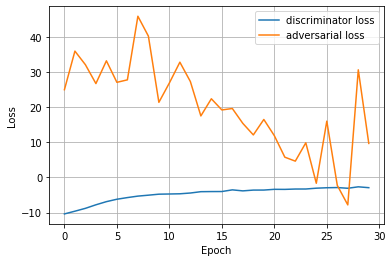

In [18]:
def plot_loss(history):
  plt.plot(history['d_loss'], label='discriminator loss')
  plt.plot(history['g_loss'], label='adversarial loss')
  # plt.ylim([0, 1.5])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [19]:
def gen_samples(n, g_model=g_model):
  sample_labels = np.random.randint(low=0, high=9, size=n*n)
  sample_labels = tf.convert_to_tensor(sample_labels)
  # one_hot_labels = tf.one_hot(sample_labels, 10)
  z_input = tf.random.normal(shape=(n*n, 128))
  z_input_and_label = [z_input, sample_labels]
  gen_images = g_model(z_input_and_label)
  return gen_images, sample_labels

In [20]:
gen_images, labels = gen_samples(5)

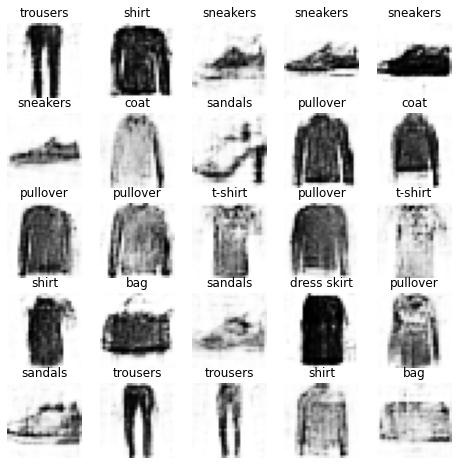

In [21]:
def show_samples(n, images, labels, label_names):
  plt.figure(figsize=(8,8))
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis(False)
    plt.imshow(images[i, :, :, 0], cmap='gray_r')
    plt.title(label_names[labels[i]])
  plt.show()

label_names = ['t-shirt','trousers','pullover','dress skirt','coat','sandals','shirt','sneakers','bag','ankle boots']
show_samples(5, gen_images, labels, label_names)

A conditional GAN with Wasserstein Loss (WGAN)

Implement the train step

In [ ]:
# define the optimizer
d_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
g_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
@tf.function
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

# Define the loss functions for the generator.
# minimize the inverted == maximize
@tf.function
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# define the Gradient Penalty
@tf.function
def gradient_penalty(batch_size, real_images, fake_images, image_labels, discriminator):
  # use an interpolated image to add to the discriminator loss

  # Get the interpolated image
  # alpha = tf.random.normal(shape=[batch_size,1,1,1], mean=0.0, stddev=1.0)
  epsilon = tf.random.normal(shape=[batch_size,1,1,1], mean=0.0, stddev=1.0)
  diff = fake_images - real_images
  interpolated = real_images_label + epsilon * diff
  # mixed_images = real_images * epsilon + fake_images * (1.0 - epsilon)

  # compute the gradient of critic(mixed_images)
  with tf.GradientTape() as gp_tape:
    gp_tape.watch(interpolated)
    # 1. Get the discriminator output for this interpolated image.
    pred = discriminator([interpolated, image_labels], training=True)

  # 2. Calculate the gradients w.r.t to this interpolated image.
  grads = gp_tape.gradient(pred, interpolated)
  # 3. Calculate the norm of the gradients.
  # the reduce sum preserve the batch size -- each image has a norm
  norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
  # get the gradient penalty - substract by 1 so that the penalty always least than 1
  gradient_penalty = tf.reduce_mean((norm - 1.0) ** 2)
  return gradient_penalty

@tf.function
def train_step(data_batch):
  real_images, image_labels = data_batch
  batch_size = real_images.shape[0]
  z_input = tf.random.normal(shape=(batch_size, 128))
  z_input_and_labels = [z_input, image_labels]
  generated_images = g_model(z_input_and_labels)
  combined_image_labels = tf.concat([image_labels, image_labels], axis=0)
  combined_images = tf.concat([generated_images, real_images], axis=0)
  labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)
  labels += 0.05 * tf.random.uniform(labels.shape)
  combined_images_and_labels = [combined_images,combined_image_labels]
  # Train the discriminator
  with tf.GradientTape() as tape:
    tape.watch(combined_images_and_labels)
    predictions = d_model(combined_images_and_labels)
    d_loss = loss_fn(labels, predictions)
  grads = tape.gradient(d_loss, d_model.trainable_weights)
  d_optimizer.apply_gradients(zip(grads, d_model.trainable_weights))

  # Train the generator
  z_input = tf.random.normal(shape=(batch_size, 128))
  misleading_labels = tf.ones((batch_size, 1))
  combined_images_and_labels = [z_input, image_labels]
  with tf.GradientTape() as tape:
    tape.watch(combined_images_and_labels)
    gen_imgs = g_model(combined_images_and_labels)
    fake_images_and_labels = [gen_imgs, image_labels]
    predictions = d_model(fake_images_and_labels)
    g_loss = loss_fn(misleading_labels, predictions)
  grads = tape.gradient(g_loss, g_model.trainable_weights)
  g_optimizer.apply_gradients(zip(grads, g_model.trainable_weights))
  return d_loss, g_loss, generated_images